Importare le librerie


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Verifica GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")
from google.colab import drive

Device utilizzato: cuda


Caricare i dati

In [ ]:
# Caricare i dati da una directory organizzata in sottocartelle per classe
drive.mount('/content/drive')
!ls /content/drive/MyDrive

train_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/train'
test_dir = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test'

# Trasformazioni delle immagini
transform = transforms.Compose([
    transforms.Resize((150, 150)), # Dimensioni uniformi
    transforms.ToTensor(),        # Conversione in tensore
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

# Caricamento del dataset
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Verifica classi
class_names = train_data.classes
print(f"Classi trovate: {class_names}")

Mounted at /content/drive
'Colab Notebooks'   Night_Wolves
Classi trovate: ['control', 'retinite']


# Definizione della CNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 37 * 37, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Inizializzazione del modello
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=87616, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


# Funzione di perdita e ottimizzazione

In [ ]:
# Funzione di perdita e ottimizzatore
criterion = nn.BCELoss()  # Cross Entropy per classificazione binaria
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate iniziale


# Addestrare il modello

In [ ]:
# Funzione di addestramento
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)

            # Azzeramento dei gradienti
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Avvio dell'addestramento
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10, Loss: 0.4846
Epoch 2/10, Loss: 0.2540
Epoch 3/10, Loss: 0.1955
Epoch 4/10, Loss: 0.1794
Epoch 5/10, Loss: 0.1709
Epoch 6/10, Loss: 0.1617
Epoch 7/10, Loss: 0.1445
Epoch 8/10, Loss: 0.1802
Epoch 9/10, Loss: 0.1499
Epoch 10/10, Loss: 0.1463


# Valutazione del modello

In [ ]:
# Funzione per valutare il modello
def evaluate(model, test_loader):
    model.eval()  # Imposta il modello in modalità di valutazione
    correct = 0
    total = 0

    with torch.no_grad():  # Disabilita il calcolo dei gradienti durante la valutazione
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()  # Predizione (0 o 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")

# Valutazione del modello sui dati di test
evaluate(model, test_loader)

Accuracy: 94.96124031007751%


# Matrice di confusione

Confusion Matrix:
[[204   5]
 [  8  41]]


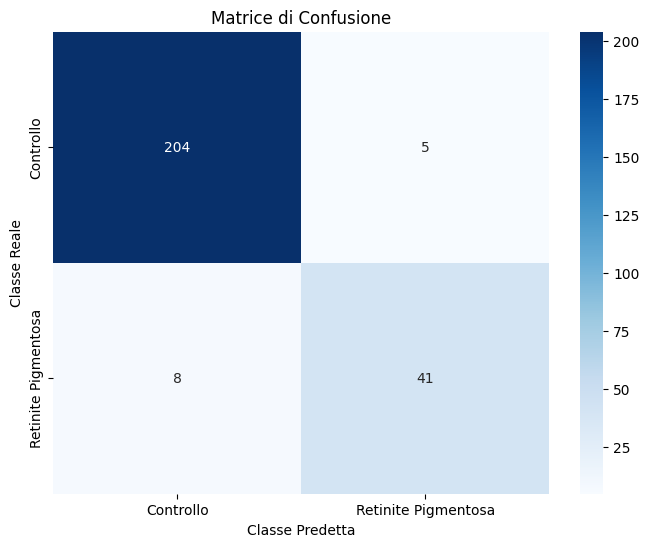

Classification Report:
                     precision    recall  f1-score   support

          Controllo       0.96      0.98      0.97       209
Retinite Pigmentosa       0.89      0.84      0.86        49

           accuracy                           0.95       258
          macro avg       0.93      0.91      0.92       258
       weighted avg       0.95      0.95      0.95       258



In [ ]:
import torch
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Funzione per calcolare e visualizzare la matrice di confusione
def confusion_matrix(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = metrics.confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Visualizzazione della matrice di confusione
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matrice di Confusione')
    plt.xlabel('Classe Predetta')
    plt.ylabel('Classe Reale')
    plt.show()

    # Report di classificazione
    print("Classification Report:")
    print(metrics.classification_report(all_labels, all_preds, target_names=class_names))

# Definisci le classi, modifica se necessario
class_names = ['Controllo', 'Retinite Pigmentosa']

# Calcolo e stampa della matrice di confusione
confusion_matrix(model, test_loader, class_names)


Utilizzare il modello

In [ ]:
from PIL import Image
import torchvision.transforms as T

# Funzione per fare una previsione su una singola immagine
def predict(model, image_path):
    model.eval()

    # Caricamento e trasformazione dell'immagine
    transform = T.Compose([
        T.Resize((150, 150)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Aggiungi una dimensione per batch
    image = image.to(device)

    # Predizione
    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        output = model(image)  # Passa l'immagine nel modello per ottenere la previsione
        prediction = (output.squeeze() > 0.5).float()  # Applica una soglia di 0.5 per classificare


    print(f"Predizione: {'Retinite Pigmentosa' if prediction == 1 else 'Controllo'}")

# Esegui una previsione su un'immagine
img_path = '/content/drive/MyDrive/Night_Wolves/RPvsControl/data/test/retinite/Retinitis Pigmentosa73.jpg'
predict(model, img_path)

Predizione: Retinite Pigmentosa
